In [0]:
import json

X = json.load(open('RNN_train_x.json'))
Y = json.load(open('RNN_train_y.json'))

In [0]:
from tqdm.notebook import tqdm
import torch

def one_hot(i, dim) :
  if type(i) == type(list()) :
    return torch.tensor(list(map(lambda x: one_hot(x, dim).tolist(), i)))
  a = torch.zeros(dim)
  a[i] = 1
  return a

class translator :
    def __init__(self, words, min_count, empty=False) :
      if not empty :
        npwords = np.array(words)
        count = [(word,(npwords==word).sum()) for word in tqdm(np.unique(words))]
        count = sorted(count, key=lambda x: x[1], reverse=True)
        d = -1
        while True :
          d += 1
          if count[d][1] < min_count :
            break
        self.dim = d+1
        self.mapping = {count[i][0] : i for i in range(d)}

    def one_hot(self, i) :
      a = torch.zeros(self.dim)
      a[i] = 1
      return a

    def __getitem__(self, i, tensor=True) :
        if type(i)==type('') :
          if tensor :
            return self.one_hot(self.mapping.get(i, self.dim-1))
          else :
            return self.one_hot(self.mapping.get(i, self.dim-1)).tolist()
        
        elif type(i)==type(1) :
          if tensor :
            return self.one_hot(i)
          else :
            return self.one_hot(i).tolist()
        
        elif type(i)==type(list()) :
          if tensor :
            return torch.tensor(list(map(lambda x: self.__getitem__(x, False), i)))
          else :
            return list(map(lambda x: self.__getitem__(x, False), i))

        else :
            return self.__getitem__(i.tolist())

    def get_item(self, i) :
        if type(i)==type('') :
            return self.mapping.get(i, self.dim-1)
        if type(i)==type(1) :
            return i
        elif type(i)==type(list()) :
            return torch.tensor(list(map(self.get_item, i)))
        else :
            return self.get_item(i.tolist())

    def save_to_file(self, name) :
      json.dump({'dim': self.dim, 'mapping': self.mapping}, open(name,'w'))

    @classmethod
    def load_from_file(cls, name) :
      f = json.load(open(name))
      self = cls([],0,True)
      self.dim = f['dim']
      self.mapping = f['mapping']
      return self

onehoter = translator.load_from_file('RNN_one_hoter.json')

In [0]:
import pandas as pd

pos_indexer = json.load(open('pos_indexer.json'))
def pos_index(l) :
  return list(map(pos_indexer.__getitem__, l))
pos_names = pd.read_csv('pos_list.csv')
def pos_name(l) :
  return list(map(lambda x: pos_names.iloc[int(x)][0], l))

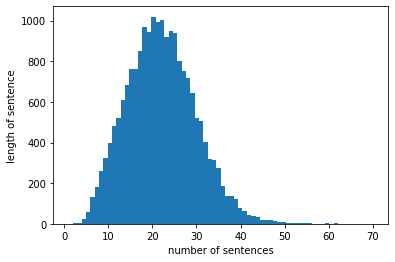

In [0]:
import matplotlib.pyplot as plt
import numpy as np

lengths = np.array(list(map(len, Y)))
plt.hist(lengths, bins=70)
plt.xlabel('number of sentences')
plt.ylabel('length of sentence')
plt.show()

In [0]:
from keras.preprocessing.sequence import pad_sequences

outdim = pos_names.shape[0]

input_data = list(map(lambda x: onehoter.get_item(x)+2, tqdm(X)))
target_data = list(map(lambda y: one_hot(pos_index(y), outdim), tqdm(Y)))

MAX_LENGTH = max(list(map(len, Y)))

x = pad_sequences(input_data, maxlen=MAX_LENGTH, padding='post')
y = pad_sequences(target_data, maxlen=MAX_LENGTH, padding='post')

In [0]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from keras.optimizers import Adam
 
model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH, )))
model.add(Embedding(onehoter.dim+2, 512))
model.add(Bidirectional(LSTM(1024, return_sequences=True)))
model.add(TimeDistributed(Dense(pos_names.shape[0])))
model.add(Activation('softmax'))
 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])
 
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 70, 512)           2423808   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 70, 2048)          12591104  
_________________________________________________________________
time_distributed_6 (TimeDist (None, 70, 42)            86058     
_________________________________________________________________
activation_6 (Activation)    (None, 70, 42)            0         
Total params: 15,100,970
Trainable params: 15,100,970
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(x, y, batch_size=128, epochs=40, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15999 samples, validate on 4000 samples
Epoch 1/40
15999/15999 [==============================] - 1065s 67ms/step - loss: 0.3365 - accuracy: 0.2386 - val_loss: 0.0640 - val_accuracy: 0.2952
Epoch 2/40
12288/15999 [======================>.......] - ETA: 3:52 - loss: 0.0528 - accuracy: 0.2956

KeyboardInterrupt: ignored